In [1]:
# Import needed packages
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 

# Import custom plot wrapper functions
from uspto_plots import lineplot, stackedbar

# Import other custom funcs
from uspto_funcs import *

# Set view options for pandas
pd.set_option('display.max_columns', 50)

In [23]:
%load_ext autoreload
%autoreload 2

# Reading in the data

The two main datasets that we will be working with are the USPTO's Cancer Moonshot Patent Data (data file available [here](https://www.uspto.gov/ip-policy/economic-research/research-datasets/cancer-moonshot-patent-data)) and the Patent Examination Research Dataset (hereafter referred to as "PatEx"). For the PatEx data, we are specifically using the 2022 release, which is available [here](https://www.uspto.gov/ip-policy/economic-research/research-datasets/patent-examination-research-dataset-public-pair). While the PatEx data is more comprehensive and attribute-rich, the Cancer Moonshot dataset is useful for my purpose because it identifies published patent applications and granted patents that are relevant to *cancer research and development*, which is the focus of this EDA project. In addition, the Moonshot dataset includes a set of fields that categorizes each invention into high-level technology categories. 

The data files that we will be using for the project are the following:

Cancer Moonshot Patent Data:
* **`Cancer Data12A.csv`**: ~270,000 patent documents spanning the 1976 to 2016 period

PatEx 2022 release:
* **`application_data.csv`**: >13 million publicly-viewable provisional and non-provisional patent applications downloaded from the Patent Examination Data System (PEDS) in June 2023;
* **`correspondence_address.csv`**: contains name and address information of the law firm, legal department, or otherwise corresponding recipient for each application in `application_data.csv`;
* **`all_inventors.csv`**: contains the names and locations of all inventors for each application, where available.

## Cancer Moonshot Patent Data

In [2]:
# Read in data
data_moonshot = pd.read_csv('data/Cancer Data12A.csv', 
                   usecols=list(range(1,5))+list(range(12,29)),
                   parse_dates=['Filing_Date', 'Grant_or_Publication_Date', 'FDA_Approval_Date'], 
                   infer_datetime_format=True)

In [3]:
# Print shape (num. of rows, num. of columns) of dataset
print(data_moonshot.shape)
print('\n')
# Check dtypes
data_moonshot.info()

(269353, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269353 entries, 0 to 269352
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Patent_or_Publication_ID          269353 non-null  object        
 1   Application_Number                269008 non-null  object        
 2   Filing_Date                       269042 non-null  datetime64[ns]
 3   Grant_or_Publication_Date         269353 non-null  datetime64[ns]
 4   Drugs_and_Chemistry               269353 non-null  int64         
 5   Diagnostic_and_Surgical_Devices   269353 non-null  int64         
 6   Radiation_Measurement             269353 non-null  int64         
 7   Data_Science                      269353 non-null  int64         
 8   Food_and_Nutrition                269353 non-null  int64         
 9   Model_Systems_and_Animals         269353 non-null  int64         
 10  Cells_and_Enzymes

In [4]:
# Sample of the dataset
data_moonshot.sample(3)

,Patent_or_Publication_ID,Application_Number,Filing_Date,Grant_or_Publication_Date,Drugs_and_Chemistry,Diagnostic_and_Surgical_Devices,Radiation_Measurement,Data_Science,Food_and_Nutrition,Model_Systems_and_Animals,Cells_and_Enzymes,Other_and_Preclassification,DNA_RNA_or_Protein_Sequence,NIH_Federal_Grant_Number,NIH_Grant_Recipient_Organization,FDA_Application_Number,FDA_Drug_Trade_Name,FDA_Approval_Date,FDA_Applicant,FDA_Ingredient,TBD
108370,US 7537918 B2,11/096240,2005-03-31,2009-05-26,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181777,US 20100041628 A1,12/448826,2008-01-15,2010-02-18,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73600,US 7130746 B2,09/975843,2001-10-12,2006-10-31,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PatEx 2022 `application_data`

In [5]:
# Grab the application numbers from Moonshot data
app_numbers = data_moonshot.Application_Number.str.replace('/', '').dropna().values
print(len(app_numbers))

269008


In [6]:
# Read in 'application_data' in chunks, filtering by app_numbers, and store in generator
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/application_data.csv', 
                 usecols=[
                     'application_number', 'filing_date','examiner_full_name', 'examiner_art_unit', 
                     'appl_status_desc', 'appl_status_date','patent_number', 'patent_issue_date'
                 ],
                 parse_dates=['filing_date', 'appl_status_date', 'patent_issue_date'],
                 infer_datetime_format=True,
                 chunksize=10000, iterator=True))

# Create new dataset by concatenating the individual chunks
data_patex = pd.concat(chunks)

In [7]:
# Print shape (num. of rows, num. of columns) of dataset
print(data_patex.shape)
print(f'{len(data_patex)/len(app_numbers)*100:.2f}% recovery')

(189282, 8)
70.36% recovery


In [8]:
# Check dtypes and other info
data_patex.dtypes

application_number            object
filing_date           datetime64[ns]
examiner_full_name            object
examiner_art_unit             object
appl_status_desc              object
appl_status_date      datetime64[ns]
patent_number                 object
patent_issue_date             object
dtype: object

In [9]:
# 'patent_issue_date' didn't get converted to datetime when reading in the CSV
# likely because of some unparsable values, so use to_datetime() to coerce
data_patex['patent_issue_date'] = pd.to_datetime(data_patex['patent_issue_date'], errors='raise')

Overall, ~70% of the applications identified in the Cancer Moonshot Patent Data were "recoverable" in the PatEx 2022 release.

## Comparison of `moonshot` and `patex`

To further understand how the two datasets might be different from each other, we can look for differences in the number of applications available for each filing year.

The [paper](https://ssrn.com/abstract=2702637) that accompanied the first release of PatEx in 2014 states that there is very poor coverage for applications filed prior to 1981 and limited coverage for applications received between the late 1970's and 2000, because prior to the implementation of the American Inventors Protection Act (AIPA) in November 2000, pre-grant applications were not published. Therefore, data for applications filed before the AIPA went into effect are not public unless those applications were granted. The documentation also notes that even for the years following AIPA implementation, coverage is not 100% because not all applications become publicly-viewable, typically for national security reasons.

How does this compare to the coverage in the Cancer Moonshot dataset during the same time period?

In [10]:
# Group by number of applications filed per year
counts_moonshot = data_moonshot.groupby(data_moonshot.Filing_Date.dt.year)['Application_Number'].count()
counts_patex = data_patex.groupby(data_patex.filing_date.dt.year)['application_number'].count()

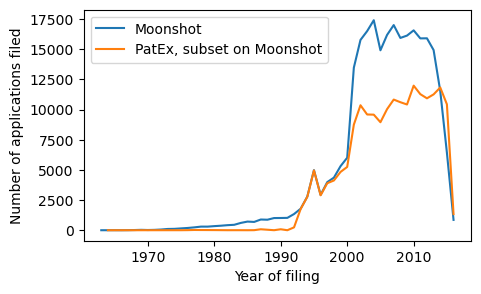

In [11]:
# Initiate figure
fig, ax = plt.subplots(figsize = (5,3))

# Plot lines
line1, = ax.plot(counts_moonshot, label='Moonshot')
line2, = ax.plot(counts_patex, label = 'PatEx, subset on Moonshot')

# Add labels
ax.legend()
ax.set_xlabel('Year of filing')
ax.set_ylabel('Number of applications filed')

plt.show()
# fig.savefig('results/moonshot-patex-counts', dpi=150, format='png', bbox_inches='tight')

Compared to the `moonshot` dataset, the number of applications that could be recovered from `patex` seemed particularly low, up until the early 1990s.

The steep drop in the number of filed applications in the last few years of both datasets makes sense. The last filing date in the `moonshot` dataset is 2016-04-12. Due to the average 18-month lag for patent applications to become published, we would expect that many patent applications filed between 2014-10-12 and 2016-04-12 (an 18-month period) would not yet be published, and therefore not be present in either dataset. 

Applications filed during this period that *do* show up in the dataset are likely those that claimed the benefit of previous applications that had been filed long before (and therefore were already published).

In [12]:
data_moonshot['Filing_Date'].max() - np.timedelta64(18, 'M')

Timestamp('2014-10-12 03:16:12')

# Exploratory Data Analysis

## Outcomes of patent applications

An easy first step is to get a sense of the statuses of the patent applications in the dataset. What percentage are granted, abandoned, or still pending?

In [13]:
patex_outcomes = data_patex[['application_number', 'appl_status_desc']].copy()

In [14]:
# Check the number of missing values
patex_outcomes.isna().sum()

# Drop rows with missing values in any column
patex_outcomes.dropna(axis=0, how='any', inplace=True)

In [15]:
import re

# A mapping dict to assign statuses based on regex patterns
outcomes_map = {
    'abandon': 'abandoned',
    'patent': 'patented',
    'response': 'pending',
    'action': 'pending',
    'mailed': 'pending',
    'docketed': 'pending',
    'preexam': 'pending'
}
outcomes_regex = re.compile(r'(?i)(abandon|patent|response|action|mailed|docketed|preexam)')

In [16]:
# Cast the column into string type
patex_outcomes['appl_status_desc'] = patex_outcomes['appl_status_desc'].astype('string')

# Use a custom function to perform categorization
patex_outcomes['outcome'] = patex_outcomes['appl_status_desc'].apply(categorize, 
                                                                     regex=outcomes_regex, 
                                                                     mapping_dict=outcomes_map)

In [17]:
patex_outcomes.sample(5)

,application_number,appl_status_desc,outcome
3714388,10411977,Patent Expired Due to NonPayment of Maintenanc...,patented
7438069,13808461,Abandoned -- Failure to Respond to an Office A...,abandoned
3587082,10298196,Patented Case,patented
2761821,09500243,Patent Expired Due to NonPayment of Maintenanc...,patented
5026276,11639939,Abandoned -- Failure to Respond to an Office A...,abandoned


In [18]:
# Group by outcome and status description
patex_outcomes_grouped = patex_outcomes.groupby(['outcome', 'appl_status_desc']).agg('count')

# Reset index to revert to normal index from MultiIndex
patex_outcomes_grouped.reset_index(inplace=True)

In [19]:
patex_outcomes_grouped.head()

,outcome,appl_status_desc,application_number
0,abandoned,Abandoned -- After Examiner's Answer or Board ...,1229
1,abandoned,Abandoned -- Failure to Pay Issue Fee,2232
2,abandoned,Abandoned -- Failure to Respond to an Office A...,67991
3,abandoned,Abandoned -- Incomplete Application (Pre-exami...,223
4,abandoned,Abandonment for Failure to Correct Drawings/Oa...,36


In [20]:
total = patex_outcomes['application_number'].count()
patex_outcomes['outcome'].value_counts()/total * 100

patented     60.989243
abandoned    38.674211
pending       0.237748
other         0.098798
Name: outcome, dtype: float64

The vast majority of applications are patented or abandoned. Only a very small fraction are pending, and an even smaller fraction are in 'other' (appeal processing, etc.).

## Pendency

One of the key questions that an individual or company planning to file a patent application might be interested in is: How long does will it take for the patent application to become *granted* (i.e., actually become a patent)? Of course, the major assumption here is that the application *will* eventually be granted. This is the outcome we care about, but it's worth keeping in mind that applications may also become abandoned, as we've seen above. Indeed, a sizeable fraction of applications in the dataset are abandoned.

The time from filing an application to the grant of that application is called *total pendency*, distinguished from other forms of pendency such as *first office action pendency* (the time from filing to the issuance of a first office action). For the sake of simplicity, total pendency will just be referred to as *pendency* for the rest of the analysis.

For the Moonshot data, we have to first identify the granted patents in order to be able to calculate pendency.

In [21]:
# Convert Patent_or_Publication_ID into string type in order to apply regex pattern
data_moonshot['Patent_or_Publication_ID'].astype('string', copy = False)

# Subset only the application IDs that follow the pattern to get granted patents
pattern = r'([\w]{2}) (\d{6,8}) ([\w]{1,2})'
moonshot_granted = data_moonshot.loc[data_moonshot['Patent_or_Publication_ID'].str.match(pattern),
                                    ['Application_Number', 
                                     'Filing_Date', 
                                     'Grant_or_Publication_Date']]

# Print shape of granted data
print(f'There are {moonshot_granted.shape[0]} granted patents in the Moonshot data')

There are 111148 granted patents in the Moonshot data


In [25]:
# Use a custom function to calculate pendency in both datasets
moonshot_granted = pendency(moonshot_granted, 'Grant_or_Publication_Date', 'Filing_Date')
patex_granted = pendency(data_patex, 'patent_issue_date', 'filing_date')

Let's create some line plots showing filing date on the x-axis and pendency on the y-axis, just to get an initial impression of how pendency has changed over time.

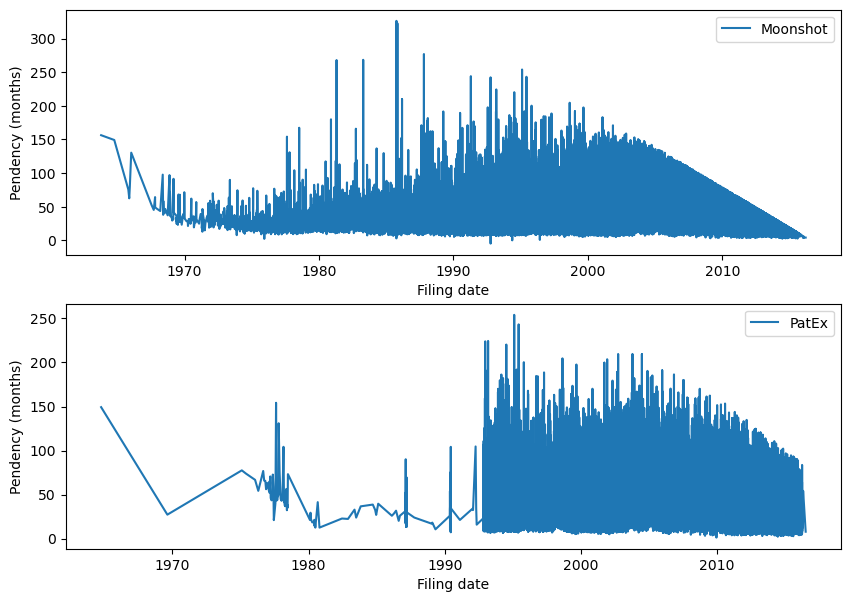

In [26]:
# Initialize figure and axes
fig, axs = plt.subplots(nrows=2, figsize=(10,7))

# Plot line plots
axs[0].plot(moonshot_granted.sort_values(by='Filing_Date')['Filing_Date'], 
            moonshot_granted.sort_values(by='Filing_Date')['pendency'], 
            label='Moonshot')
axs[1].plot(patex_granted.sort_values(by='filing_date')['filing_date'], 
            patex_granted.sort_values(by='filing_date')['pendency'], 
            label='PatEx')

# Add axis labels and legend
for ax in axs:
    ax.set_xlabel('Filing date')
    ax.set_ylabel('Pendency (months)')
    ax.legend()
    
plt.show()
# fig.savefig('results/moonshot-patex-pendency', dpi=150, format='png', bbox_inches='tight')

There's a lot of variation in the graphs above and it's hard to tell clearly how pendency changes over time. 

There's also clearly incomplete coverage in the early decades (1970s, 1980s) for both datasets. Notice especially the "sparseness" of data in `PatEx` during this period. Comparatively, `Moonshot` has more coverage for these decades than `PatEx`. This corroborates what we already saw earlier.

For `PatEx`, the data becomes much less sparse in the early 1990s, showing that there was a big jump in coverage at some point.  

In [27]:
# Look at number of applications filed per year to find
# in which year the increase in coverage occurred
apps_per_year = patex_granted.groupby(patex_granted['filing_date'].dt.year)['application_number'].count()

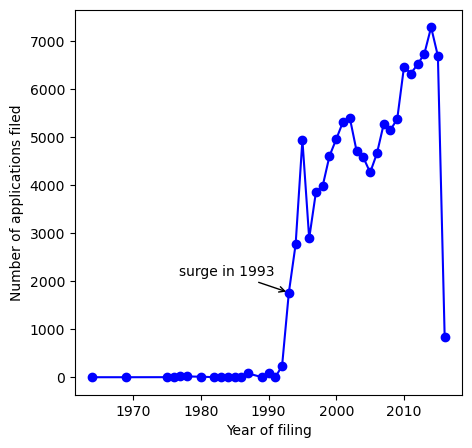

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(apps_per_year.index, apps_per_year.values, 'bo-')
ax.annotate('surge in 1993', xy=(1993, apps_per_year.loc[1993]), 
            xytext=(-10, 10), textcoords='offset points', 
            ha='right', va='bottom', arrowprops={'arrowstyle': '->'})
ax.set(xlabel='Year of filing', ylabel='Number of applications filed')
plt.show()

In the `PatEx` dataset, we can see that there was a big jump from 1992 to 1993 in the number of applications filed. We have to accept that, by using the `PatEx` data, we're going to get poorer coverage before 1993 in exchange for more updated information for the applications filed more in the later years of the dataset (2000s-2010s).

Given the 18-month publication lag discussed above, it also makes sense to limit the `PatEx` dataset to applications filed before 2015.  

In [29]:
# Subset PatEx granted df for apps filed after 1993 and before 2015
patex_granted = patex_granted.loc[(patex_granted['filing_date'] > '1993')
                                 & (patex_granted['filing_date'] < '2015')].copy()

In [32]:
# Check that the data has been correctly subset
print(f"Earliest filing date: {patex_granted['filing_date'].min()}, \n"
      f"Latest filing date: {patex_granted['filing_date'].max()}")

Earliest filing date: 1993-01-04 00:00:00, 
Latest filing date: 2014-12-31 00:00:00


### Distribution of pendency
We can plot the pendency as a distribution to visualize the spread of the data.

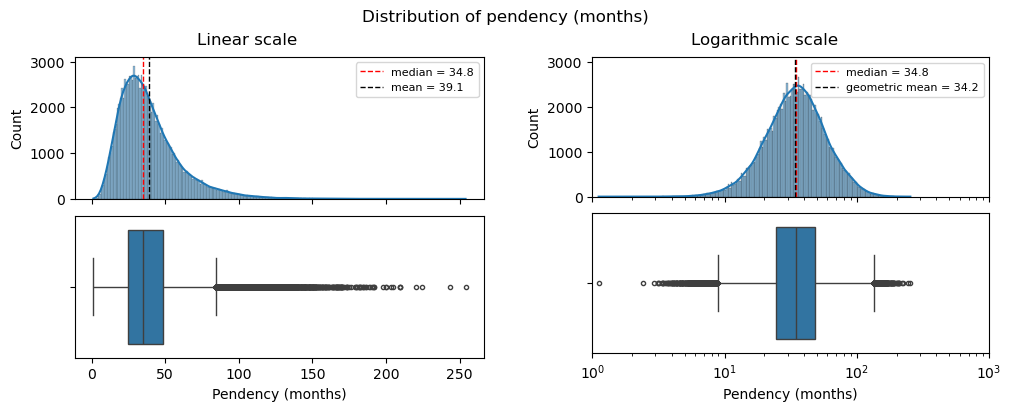

In [34]:
# Initialize fig, subfig, and axes
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(ncols=2, wspace=0.07)
axsLeft = subfigs[0].subplots(nrows=2, sharex=True)
axsRight = subfigs[1].subplots(nrows=2, sharex=True)

# Create plots
sns.histplot(data=patex_granted, x='pendency', kde=True, ax=axsLeft[0])
sns.boxplot(data=patex_granted, x='pendency', fliersize=3, ax=axsLeft[1])
sns.histplot(data=patex_granted, x='pendency', kde=True, log_scale=True, ax=axsRight[0])
sns.boxplot(data=patex_granted, x='pendency', fliersize=3, log_scale=True, ax=axsRight[1])

# Set labels and titles
for ax in axsLeft:
    ax.set_xlabel('Pendency (months)')
for ax in axsRight:
    ax.set_xlabel('Pendency (months)')
subfigs[0].suptitle('Linear scale')
subfigs[1].suptitle('Logarithmic scale')
fig.suptitle('Distribution of pendency (months)', fontsize='large')

# Add annotations and legends to show mean, median
median = patex_granted['pendency'].median()
mean = patex_granted['pendency'].mean()
# Calculate geometric mean
log_mean = np.mean(np.log10(patex_granted['pendency']))
geom_mean = 10**log_mean
# Set vline parameters
vline_params = dict(ls='dashed', lw=1)
axsLeft[0].axvline(median, color='red', label=f'median = {median:.1f}', **vline_params)
axsLeft[0].axvline(mean, color='black', label=f'mean = {mean:.1f}', **vline_params)
axsLeft[0].legend(fontsize=8)
axsRight[0].axvline(median, color='red', label=f'median = {median:.1f}', **vline_params)
axsRight[0].axvline(geom_mean, color='black', label=f'geometric mean = {geom_mean:.1f}', **vline_params)
axsRight[0].legend(fontsize=8)

# Adjust the ylims
for ax in axsLeft[0], axsRight[0]:
    ax.set_ylim(0, 3100)
    
# Adjust xlim for lognormal graphs
for ax in axsRight:
    ax.set_xlim(1, 1000)
    
plt.show()
# fig.savefig('results/patex-granted-distribution', dpi=150, format='png', bbox_inches='tight')

In [35]:
# Get some summary stats
patex_granted['pendency'].describe()

count    107846.000000
mean         39.115449
std          21.026931
min           1.117066
25%          24.575453
50%          34.760467
75%          48.493809
max         254.099674
Name: pendency, dtype: float64

### Change in median pendency over time

To help see how pendency changes over time, we can plot the median pendency over the different filing years.

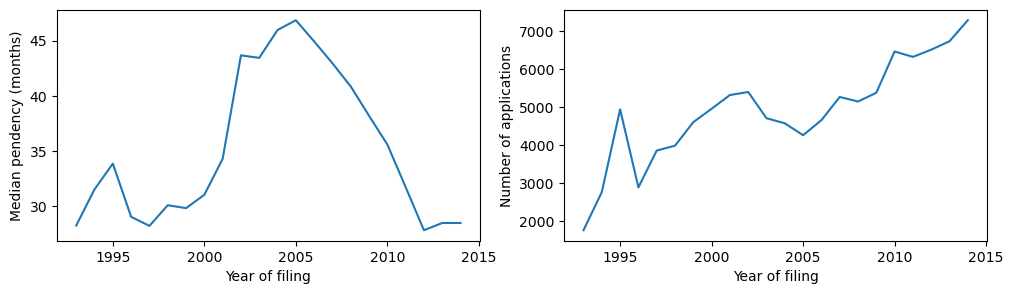

In [36]:
# Get data
median_pendency = patex_granted.groupby(patex_granted['filing_date'].dt.year)['pendency'].median()
appls_filed = patex_granted.groupby(patex_granted['filing_date'].dt.year)['application_number'].count()

# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)

# Plot line plots
ax1.plot(median_pendency)
ax2.plot(appls_filed)

# Add labels
for ax in (ax1, ax2):
    ax.set_xlabel('Year of filing')
ax1.set_ylabel('Median pendency (months)')
ax2.set_ylabel('Number of applications')

plt.show()
# fig.savefig('results/patex-pendency-vs-filing-year', dpi=150, format='png', bbox_inches='tight')

### Effect of patent category on pendency

We can also look at the distributions of pendency for different categories, to see if there are differences between categories.

Now's the time we need to merge `patex_granted` with our `Moonshot` data to get the categories.

The `Moonshot` data is currently in a "wide" format (one row for each patent application). Let's reshape it to a "stacked" or "long" format so that data about the different patent categories are in the same column.

In [37]:
# Remove the slashes in 'Application_Number' for easy merging later
data_moonshot['Application_Number'] = data_moonshot['Application_Number'].str.replace('/','')

In [38]:
# Subset the data to only application number, filing date and categories
cat_moonshot = data_moonshot.loc[:, ['Application_Number', 'Filing_Date', *data_moonshot.columns[4:13]]]

In [39]:
# Replace the 1s in the category columns with the category names
cat_moonshot = cat_moonshot.replace(to_replace=1, 
                                    value=dict(zip(cat_moonshot.columns[2:], cat_moonshot.columns[2:])))

# Transform to long format
cat_moonshot = pd.melt(
    cat_moonshot, 
    id_vars=list(cat_moonshot.columns[:2]),
    value_vars=list(cat_moonshot.columns[2:]), 
    value_name='category'
)

# Drop the variable column
cat_moonshot.drop('variable', axis=1, inplace=True)

# Drop rows that have a 0 in new 'category' column
cat_moonshot = cat_moonshot.loc[cat_moonshot['category'] != 0]

In [40]:
cat_moonshot.sample()

,Application_Number,Filing_Date,category
148161,11909940,2006-03-31,Drugs_and_Chemistry


In [41]:
# Merge with 'patex_granted' and drop unneeded columns
patex_granted_cat = pd.merge(patex_granted, cat_moonshot, 
                             how='left', left_on='application_number', 
                             right_on='Application_Number').drop(['Application_Number', 'Filing_Date'], axis=1)

Now we can answer the question: Does pendency differ between patent categories?

In [42]:
patex_granted_cat.head(5)

,application_number,filing_date,examiner_full_name,examiner_art_unit,appl_status_desc,appl_status_date,patent_number,patent_issue_date,pendency,category
0,07961924,1993-01-04,"BOND, ROBERT",1202,Patented Case,1994-04-28,5310900,1994-05-10,16.131748,Drugs_and_Chemistry
1,08000158,1993-01-04,"WANG, GIAN",1812,Patented Case,1994-03-04,5294700,1994-03-15,14.291875,Drugs_and_Chemistry
2,08000931,1993-01-05,"GRIMES, ERIC BURTON",1814,Patent Expired Due to NonPayment of Maintenanc...,2018-01-26,5578477,1996-11-26,46.686790,Cells_and_Enzymes
3,07960405,1993-01-06,"GOLDBERG, JEROME D",1205,Patent Expired Due to NonPayment of Maintenanc...,2018-01-26,5439921,1995-08-08,31.015011,Drugs_and_Chemistry
4,08001010,1993-01-06,"TILL, MARY C",1209,Patent Expired Due to NonPayment of Maintenanc...,2006-10-12,5346895,1994-09-13,20.205754,Drugs_and_Chemistry


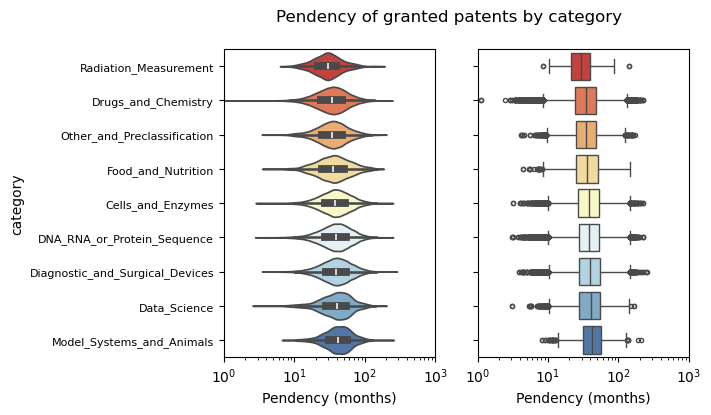

In [43]:
# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,4), sharey=True)

# Setting the order by increasing median
order = patex_granted_cat.groupby('category')['pendency'].mean().sort_values().index

# Create plots
sns.violinplot(patex_granted_cat, x='pendency', y='category', order=order, 
               hue='category', hue_order=order, palette='RdYlBu', log_scale=True, 
               ax=ax1)
sns.boxplot(patex_granted_cat, x='pendency', y='category', order=order,
            hue='category', hue_order=order, palette='RdYlBu', fliersize=3, 
            log_scale=True, ax=ax2)

# Add plot titles and axis labels
for ax in (ax1, ax2):
    ax.set_xlabel('Pendency (months)')
    ax.set_xlim(1, 1000)
    # Show only outer y label
    ax.label_outer()
ax1.tick_params(axis='y', labelsize=8)
fig.suptitle('Pendency of granted patents by category')

plt.show()
# fig.savefig('results/pendency-by-category', dpi=150, format='png', bbox_inches='tight')

Visually, there doesn't appear to be a stark difference in the distribution of pendency values between different categories. 

In [44]:
patex_granted_cat.groupby('category')['pendency'].median().sort_values()

category
Radiation_Measurement              29.799380
Drugs_and_Chemistry                34.267644
Other_and_Preclassification        34.629048
Food_and_Nutrition                 35.778969
Cells_and_Enzymes                  37.980246
DNA_RNA_or_Protein_Sequence        38.768763
Diagnostic_and_Surgical_Devices    39.064457
Data_Science                       40.247233
Model_Systems_and_Animals          41.988542
Name: pendency, dtype: float64

The difference between the median pendency of radiation measurement-related patents and model systems and animals-related patents is almost a year. 

Can we tease out any other differences between categories in terms of pendency? How has pendency changed over time for each category? 

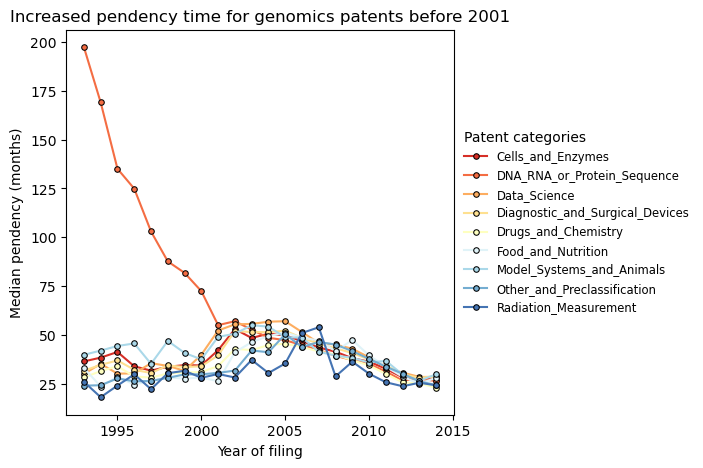

In [45]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(5,5))

# Group data by category and filing year 
grouped = (patex_granted_cat
        .groupby(['category', patex_granted_cat['filing_date'].dt.year])[['pendency']]
        .median()
        .reset_index()
          )

# Plot line plot
lineplot(grouped, x='filing_date', y='pendency', 
         hue='category', xlabel='Year of filing', ylabel='Median pendency (months)')

# Add title
ax.set_title('Increased pendency time for genomics patents before 2001')

plt.show()
# fig.savefig('results/pendency-by-category-by-year', dpi=150, format='png', bbox_inches='tight')

In [50]:
# Get counts of apps filed per year for genomics patents
dna_grouped = patex_granted_cat.groupby('category').get_group('DNA_RNA_or_Protein_Sequence')
dna_grouped.groupby(grouped['filing_date'].dt.year)['application_number'].agg('count')

filing_date
1993       2
1994       9
1995      30
1996      25
1997      49
1998     110
1999     212
2000     373
2001    1982
2002    3057
2003    2952
2004    3341
2005    2992
2006    3477
2007    3960
2008    3863
2009    3986
2010    4678
2011    4501
2012    4496
2013    4413
2014    3720
Name: application_number, dtype: int64

Caveat: There were not a lot of applications filed for genomics applications in 1993 and 1994, so the values for those two years are probably not very reliable.

### Examiner effect on pendency

Once an application is filed, it's assigned to an examiner in the appropriate art unit. The assignment system may take into account each examiner's docket (but I am not well-versed on how work gets assigned to examiners at the USPTO), but the bottom line is that applicants have no way of "choosing" who their examiner will be. 

An obvious question to ask here is, 'Are there differences between examiners in terms of pendency?'

In [74]:
# Remove rows with NaNs in examiner name
examiner_df = patex_granted.loc[~patex_granted['examiner_full_name'].isna()].copy()

In [75]:
# Check the number of NaNs
examiner_df.isna().sum()

application_number    0
filing_date           0
examiner_full_name    0
examiner_art_unit     0
appl_status_desc      0
appl_status_date      0
patent_number         0
patent_issue_date     0
pendency              0
dtype: int64

As a way to compare between examiners, we can compare the mean pendency (with 95% CI) of the fastest and slowest examiners. 

In [81]:
# Use a custom function to obtain pendency stats for each examiner
examiner_stats, fastest, slowest = examiner_calc(examiner_df)

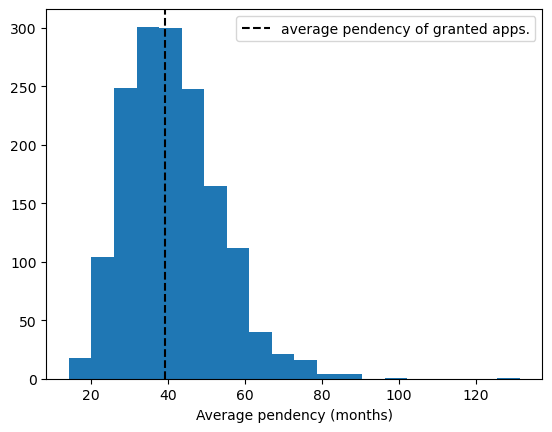

In [82]:
# Quick plot to show distribution of average pendency amongst examiners
plt.hist(examiner_stats['mean'], bins=20)
plt.xlabel('Average pendency (months)')
plt.axvline(patex_granted['pendency'].mean(), color='black', linestyle='dashed', 
            label='average pendency of granted apps.')
plt.legend()

In [83]:
examiner_stats.describe()

,mean,std,count,sem,lower,upper,meCI
count,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,41.227586,17.857766,66.123737,3.763234,32.713756,49.741415,8.513829
std,12.170904,7.350220,97.866566,2.729258,10.456054,16.897775,7.021470
min,14.226165,2.813211,5.000000,0.492058,-0.578267,17.068019,0.966965
25%,32.337284,12.274846,10.000000,1.842924,24.847743,37.541728,3.760208
50%,39.830764,17.288360,26.000000,2.949372,32.498777,46.971831,6.146362
75%,48.319952,22.338040,75.250000,4.997611,39.908295,57.991413,11.040192
max,131.337399,48.843969,761.000000,19.176594,82.042396,180.632402,51.592968


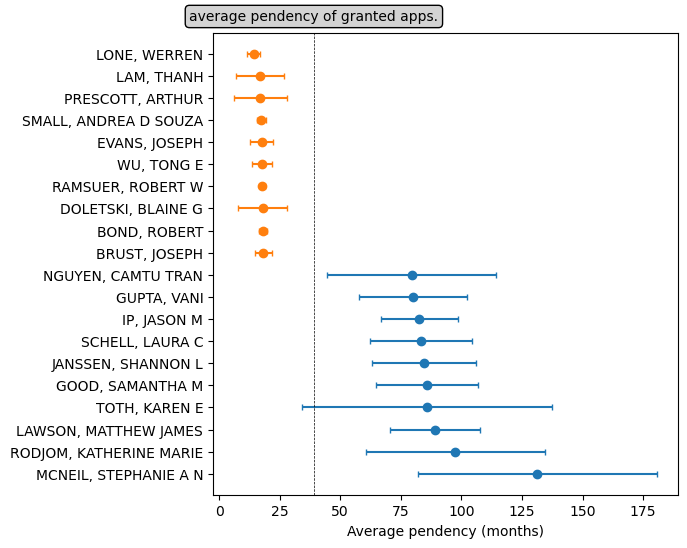

In [84]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(6,6))

# Plot the average pendency with 95% CI for the slowest and fastest examiners
for data in slowest, fastest:
    ax.errorbar(data=data, x='mean',y='examiner_full_name', xerr='meCI', fmt='o', capsize=2)

# Add a vertical line to indicate the average pendency of granted apps
ax.axvline(patex_granted['pendency'].mean(), color='black', linestyle='dashed', linewidth='0.5')

# Annotate the line
ax.text(x=patex_granted['pendency'].mean(), y=1.02, 
        s='average pendency of granted apps.', 
        ha='center', va='bottom', 
        bbox=dict(boxstyle='round', fc='lightgray'), 
        transform=ax.get_xaxis_transform())

# Add labels
ax.set_xlabel('Average pendency (months)')

plt.show()
# fig.savefig('results/slowest-fastest-examiners', dpi=150, format='png', bbox_inches='tight')

Can the average pendency for an examiner tell us anything about how "easy" or "difficult" that particular examiner is? A potential way of determing the difficulty of an examiner is to calculate the ratio of allowed to abandoned cases for each examiner (possibly within a specified timeframe), e.g., a "grant rate." This is somewhat similar to the methodology that [PatentBots](https://www.patentbots.com/stats/) uses to assign a "difficulty ranking" to examiners in its database. How does an examiner's average pendency time correlate with PatentBot's difficulty ranking? 

In [85]:
# To align more closely with PatentBot's methodology,
# let's look at data from more recent patent applications filed after 2010
recent_examiner_stats, recent_fastest, recent_slowest = examiner_calc(examiner_df, cutoff=2010)

In [86]:
recent_examiner_stats.head()

,examiner_full_name,mean,std,count,sem,lower,upper,meCI
0,"ABDI, AMARA",28.663148,10.601349,12,3.060346,21.927373,35.398924,6.735776
1,"ABOUELELA, MAY A",42.985140,26.169333,9,8.723111,22.869610,63.100670,20.115530
2,"ADZAMLI, KOFI",28.006442,12.225179,7,4.620683,16.700037,39.312847,11.306405
3,"AEDER, SEAN E",33.880340,16.807533,137,1.435964,31.040633,36.720047,2.839707
4,"AFREMOVA, VERA",50.780509,32.801983,5,14.669493,10.051468,91.509550,40.729041


#### Random sampling of examiners
A random sample of 25 examiners was generated.

In [87]:
random_sample = recent_examiner_stats[['examiner_full_name', 'mean']].sample(25)

From there, the CSV file was exported and updated with the PatentBot ranking for each examiner, where available, by manually looking up the examiner in PatentBots. This part of the analysis happened outside of the notebook.

In [88]:
# Load updated csv with PatentBot ranking
random_sample = pd.read_csv('data/random_sample_examiners.csv', usecols=[1, 2, 3], na_values='None')
random_sample = random_sample.dropna(axis=0)

What is the relationship between PatentBot ranking and average pendency of examiners? We can look at the correlation between an examiner's PatentBots rank and their average pendency.

In [89]:
# Calculate Pearson's correlation coefficient
ranking = random_sample['patent_bots_rank'].to_numpy()
mean = random_sample['mean'].to_numpy()
stats.pearsonr(ranking, mean)

PearsonRResult(statistic=0.5627816794248822, pvalue=0.009784569571179324)

We can also try to fit a linear regression model to the data:

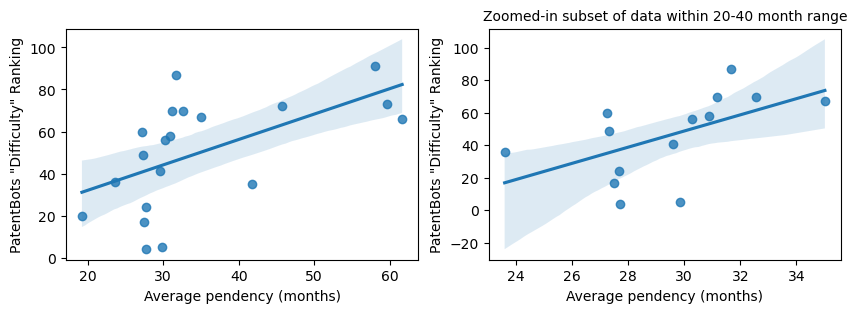

In [107]:
# Initialize fig and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))

# Plot regression plot
sns.regplot(data=random_sample, x='mean', y='patent_bots_rank', ax=ax1)
# 'Zoom in' on the regression over a subset of the data
subset = random_sample[(random_sample['mean'] > 20) & (random_sample['mean'] < 40)]
sns.regplot(data=subset, x='mean', y='patent_bots_rank', ax=ax2)

# Add labels
for ax in (ax1, ax2):
    ax.set_ylabel('PatentBots "Difficulty" Ranking')
    ax.set_xlabel('Average pendency (months)')
ax2.set_title(f'Zoomed-in subset of data within 20-40 month range', fontsize='medium')
    
plt.show()

#### Stratified sampling of examiners
Another way of sampling is by first binning the data (e.g., into quartiles), then randomly selecting *n* samples from each quartile. This helps to achieve a better representation across the range of values. 

As above, the resulting dataframe was exported and the PatentBots ranking was manually added.  

In [91]:
# Bin data into quartiles and assign a label to each data point 
# in a new column indicating quartile membership
recent_examiner_stats['quartile'] = pd.qcut(recent_examiner_stats['mean'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Sample from each quartile
q1 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q1'].sample(10, random_state=8)
q2 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q2'].sample(10, random_state=8)
q3 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q3'].sample(10, random_state=8)
q4 = recent_examiner_stats.loc[recent_examiner_stats['quartile'] == 'Q4'].sample(10, random_state=8)

# Concatenate all the samples
stratified_sample = pd.concat([q1, q2, q3, q4])

In [92]:
# Load updated csv with PatentBot ranking
stratified_sample = pd.read_csv('data/stratified_sample_examiners.csv', usecols=[0,1,9], na_values='None')

# Drop NaN values
stratified_sample = stratified_sample.dropna(axis=0)

In [93]:
# Calculate the Pearson correlation coefficient
s_ranking = stratified_sample['patent_bots_rank'].to_numpy()
s_mean = stratified_sample['mean'].to_numpy()
stats.pearsonr(s_ranking, s_mean)

PearsonRResult(statistic=0.6500841154365138, pvalue=0.0005846345475010717)

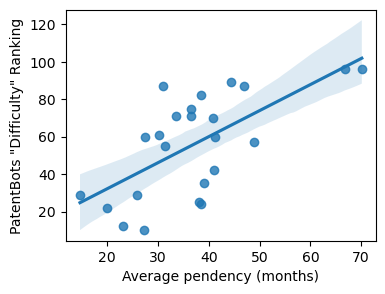

In [94]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Plot regression plot for stratified samples
sns.regplot(data=stratified_sample, x='mean', y='patent_bots_rank', ax=ax)

# Add labels, adjust ylim
ax.set_ylabel('PatentBots "Difficulty" Ranking')
ax.set_xlabel('Average pendency (months)')

plt.show()

#### Pooled samples of examiners
We can pool all the data that we've randomly sampled in both approaches, and calculate the Pearson *r* and plot a regression line for this pooled data.

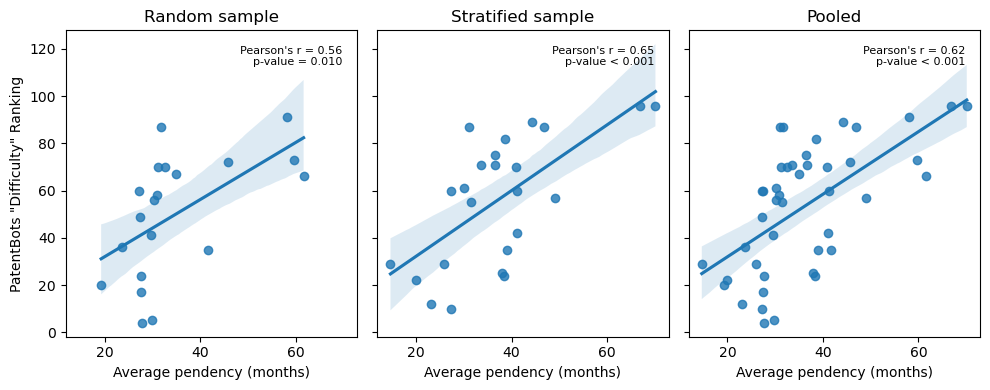

In [95]:
# Pool all the data
combined = pd.concat([random_sample, stratified_sample], axis=0)
data_list = [random_sample, stratified_sample, combined]

# Custom function to calculate Pearson correlation coefficients
def get_corr_coeffs(data_list):
    coeffs = []
    for data in data_list:
        ranking = data['patent_bots_rank'].to_numpy()
        mean = data['mean'].to_numpy()
        coeff = stats.pearsonr(ranking, mean)
        coeffs.append(coeff)
    return coeffs

# Initialize figure
fig, axs = plt.subplots(ncols=3, figsize=(10, 4), sharey=True, sharex=True, layout='tight')

# Plot regression lines
for df, ax in zip(data_list, axs):
    sns.regplot(data=df, x='mean', y='patent_bots_rank', ax=ax)
    ax.label_outer()
    ax.set_xlabel('Average pendency (months)')

# Add labels
axs[0].set_ylabel('PatentBots "Difficulty" Ranking')
axs[0].set_title('Random sample')
axs[1].set_title('Stratified sample')
axs[2].set_title('Pooled')

# Annotate with Pearson's coefficient and p-values
coeffs = get_corr_coeffs(data_list)
for _, ax, coeff in zip(data_list, axs, coeffs):
    ax.text(0.95, 0.95, f"Pearson's r = {coeff[0]:.2f}\n"
                        f"p-value {'< 0.001' if coeff[1] < 0.001 else f'= {coeff[1]:.3f}'}", 
               transform=ax.transAxes, fontsize=8, ha='right', va='top')

plt.show()
# fig.savefig('results/examiner-samples-linreg', dpi=150, format='png', bbox_inches='tight')

### Effect of company size or law firm on pendency

Question: Does the size of a company or the law firm that is representing the applicant/company in the filing affect pendency?

Correspondence data is stored in a CSV file called `correspondence_address` as part of the PatEx 2022 release. In most cases the entity is a law firm or the legal department of a commercial enterprise.

In [96]:
app_numbers = patex_granted['application_number'].values

In [97]:
# Read in correspondence_address in chunks and store filtered chunks in a generator called chunks
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/correspondence_address.csv', 
                 usecols = ['application_number','correspondence_name'],
                 dtype = {'correspondence_name':'string'}, chunksize = 10000, iterator=True))

# Create new dataframe by concatenating the individual chunks
patex_corres = pd.concat(chunks)

In [98]:
# Drop rows for which 'correspondence_name' is NaN
patex_corres = patex_corres.loc[~patex_corres['correspondence_name'].isna()].copy()

Source for list of largest biotech/pharma companies [here](https://companiesmarketcap.com/biotech/largest-companies-by-market-cap/). I grabbed the top 20 companies by market cap, as captured on October 2, 2023.

In [99]:
# Regex patterns for biotech company names
biotech_patterns = '|'.join((
    'Eli\sLilly','Novo\sNordisk','J[ohnson]*\s*&\s*J[ohnson]*','Novo\sNordisk','AbbVie','Merck',
    '\bRoche\b','Novartis','A[stra]*Z[eneca]*','Thermo\s*Fisher\s*Scientific','Pfizer','Amgen','Sanofi',
    'B[ristol]*[-\s]*M[yers]*\s*S[quibb]*','Gilead','Vertex','Regeneron','Zoetis','CSL',
    'G[laxo]*\s*S[mith]*\s*K[line]*','Daiichi'))

In [100]:
# Test if 'correspondence_name' contains a match to biotech_patterns and output result to new column
patex_corres['large_biotech'] = patex_corres['correspondence_name'].str.contains(biotech_patterns, case=False)

Source for rankings of top life sciences law firms in 2023 from [here](https://chambers.com/legal-rankings/life-sciences-usa-nationwide-5:376:12788:1).

In [101]:
# Create firm regex patterns
firm_patterns = '|'.join(['Cooley','Covington','Goodwin','Latham & Watkins','WilmerHale','Ropes & Gray','Sidley','Wilson Sonsini',
                          'A[rnold]*\s*&\s*P[orter]*','Gibson[,\s]*Dunn','Hogan Lovells','K[irkland]*\s*&\s*E[llis]*',
                          'Mo[rrison]*\s?&?\s?Fo[erster]*','Dechert','\bDLA\b','Fenwick','Jones Day','McDermott','Mintz',
                          'Morgan[\s,]*Lewis','Quinn Emanuel','\bWeil\b[\S]+','W[hite]*\s*&\s*C[ase]*','(?<!Morgan & )\bFinnegan\b',
                          '(?<!Morgan and )\bFinnegan\b','\\bBaker\\b\\s+Botts','\bBaker\b\s+[&\s]*Mckenzie','^Choate',
                          'Cravath','Greenberg Traurig','Hastings','Venable','Rakoczy'])

In [102]:
# Test if 'correspondence_name' contains a match to firm_patterns and output result to new column
patex_corres['top_firm'] = patex_corres['correspondence_name'].str.contains(firm_patterns, case=False)

In [103]:
patex_corres.head(10)

,application_number,correspondence_name,large_biotech,top_firm
1519092,07961924,MORGAN & FINNEGAN,False,False
1519185,08000158,Pfizer Inc.,True,False
1519848,08000931,Crowell/BGL,False,False
1519862,07960405,NIXON & VANDERHYE,False,False
1519953,08001010,GABOR L. SZEKERES,False,False
1519954,08001009,GABOR L. SZEKERES,False,False
1520055,08001136,NOVARTIS PHARMACEUTICAL CORPORATION,True,False
1520079,08001229,"OBLON, MCCLELLAND, MAIER & NEUSTADT, L.L.P.",False,False
1520169,08001564,BIERMAN AND MUSERLIAN,False,False
1520261,07960389,EDWIN P. CHING,False,False


In [104]:
# Grab 'pendency' data from 'patex_granted' and merge
patex_corres = patex_corres.merge(patex_granted[['application_number', 'pendency']], 
                                  how='left', on='application_number')

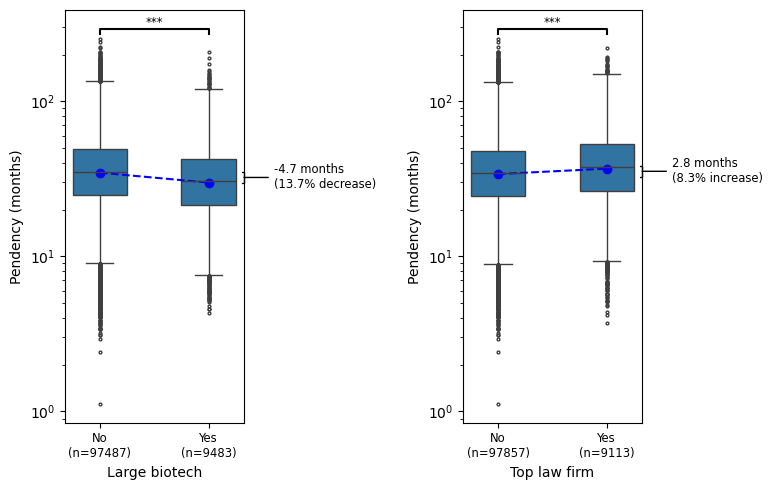

In [109]:
# Initialize figure, subfigs, and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, layout='tight', figsize=(8, 5))

# Plot the box plots
for var, ax in zip(['large_biotech', 'top_firm'], (ax1, ax2)):
    ax.set_yscale('log')
    sns.boxplot(patex_corres, x=var, y='pendency',
                width=.5, fliersize=2, ax=ax)

# Use custom functiont to derive stats
mean_stats = []
for var in ['large_biotech', 'top_firm']:
    mean_stats.append(mean_diff_sig(patex_corres, var).values())
for (cm, tm, md, dp, t, p), ax in zip(mean_stats, [ax1, ax2]):
    # Plot line plots showing diff in geom means
    ax.plot([0, 1], [cm, tm], 'bo--')
    # Add brackets to annotate with some stats 
    x = 1.3
    w = .3
    ax.annotate(f"{md:.1f} months\n({abs(dp):.1f}% {'increase' if md > 0 else 'decrease'})", 
                xy=(x, (cm+tm)*.5), xycoords='data', 
                xytext=(x+w, (cm+tm)*.5), textcoords='data', 
                va='center', ha='left', 
                arrowprops=dict(arrowstyle=f"-[, widthB=0.5, angleB=0", 
                                connectionstyle="arc3"), fontsize='small')
    # Add p-value brackets
    x1, x2 = 0, 1
    y, h = patex_corres['pendency'].max() + 20, 20
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='k')
    ax.text((x1+x2)*.5, y+h, 
            f"{'***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns'}", 
            ha='center', va='bottom', fontsize='small')

# Set labels for xticks, showing n
def n_equals(df_in, var):
    return len(df_in[df_in[var] == False]['pendency']), len(df_in[df_in[var] == True]['pendency'])

ns = [n_equals(patex_corres, 'large_biotech'), n_equals(patex_corres, 'top_firm')]
for nns, ax in zip(ns, (ax1, ax2)):
    xticks = ax.get_xticks()
    ax.set_xticks(xticks, labels=[
        f'No\n(n={nns[0]})', 
        f'Yes\n(n={nns[1]})'], fontsize='small'
)

# Set labels for y- and x-axes
ax1.set_xlabel('Large biotech')
ax2.set_xlabel('Top law firm')
for ax in ax1, ax2:
    ax.set_ylabel('Pendency (months)')
    
plt.show()
# fig.savefig('results/biotech-firm-pendency', format='png', dpi=150)

In [110]:
# Find the proportion of apps. filed by top firms
biotech_firm_prop = (patex_corres
                 .groupby('large_biotech')['top_firm']
                 .value_counts(normalize=True)
                 .mul(100)
                 .round(2)
                 .unstack()
)

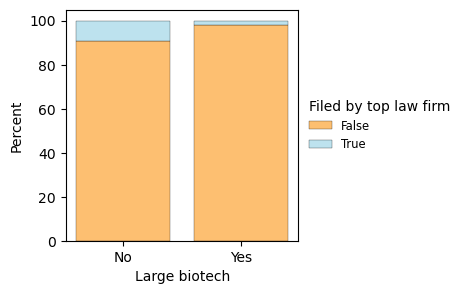

In [111]:
# Initialize figure
fig, ax = plt.subplots(figsize=(3, 3))

# Make stacked bar plot
stackedbar(biotech_firm_prop, ax=ax, 
           xlabel='Large biotech', ylabel='Percent', legend_title='Filed by top law firm')

# Set xticks
ax.set_xticks([0, 1], labels=['No', 'Yes'])

plt.show()
# fig.savefig('results/prop-large-firm', format='png', dpi=150, bbox_inches='tight')

## The rise of genomics patents

### Change in categories of inventions filed over time

Question: Can we see any trends in the categories of patents being filed over time?

In [112]:
# Subset `cat_moonshot` to filing dates between 1976 to 2014
cat_moonshot = cat_moonshot.loc[(cat_moonshot['Filing_Date'] > '1976') 
                                & (cat_moonshot['Filing_Date'] < '2015')]

In [113]:
# Group by the filing date, then aggregate the data to express the categories as proportions by filing year
cat_moonshot_prop = (cat_moonshot
                 .groupby(cat_moonshot['Filing_Date'].dt.year)['category']
                 .value_counts(normalize=True)
                 .mul(100)
                 .round(2)
                 .unstack()
                 .fillna(0)
)

In [114]:
# Sort the category columns by which category takes up the largest share in the earliest year
cat_moonshot_prop.sort_values(by=cat_moonshot_prop.index.min(), axis=1, ascending=True, inplace=True)

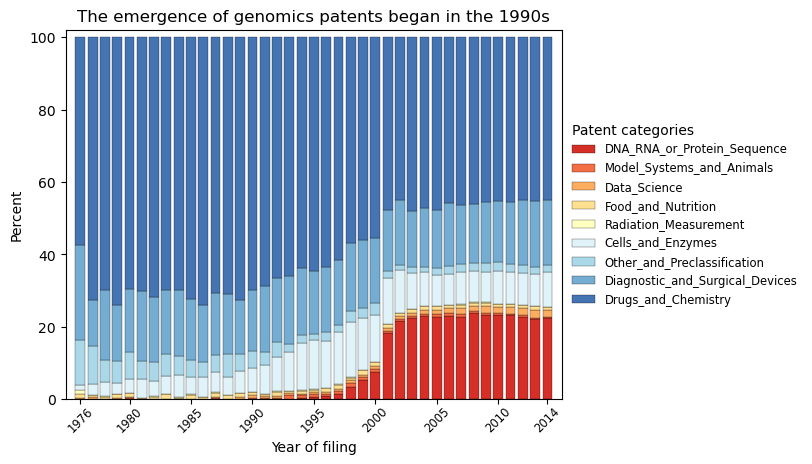

In [115]:
# Initialize figure
fig, ax = plt.subplots()

# Make stacked bar plot
stackedbar(data=cat_moonshot_prop, ax=ax, 
           xlabel='Year of filing', ylabel='Percent', 
           legend_title='Patent categories')

# Set and adjust title and xticks
ax.set(xticks=[1976, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014], 
       title=f'The emergence of genomics patents began in the 1990s')
ax.tick_params(axis='x', labelsize='small', rotation=45, pad=0.1)

# Adjust margins
ax.margins(0.02, 0.02)

plt.show()
# fig.savefig('results/prop-categories-by-year', dpi=150, format='png', bbox_inches='tight')

We can also express the category data as absolute values instead of proportions.

In [116]:
# Express data as counts instead of proportions
cat_moonshot_count = (cat_moonshot
                      .groupby(cat_moonshot['Filing_Date'].dt.year)['category']
                      .value_counts()
                      .unstack()
                     )

# Pivot from wide to long format
cat_moonshot_count = cat_moonshot_count.melt(ignore_index=False, value_name='counts').reset_index()

In [117]:
cat_moonshot_count.head()

,Filing_Date,category,counts
0,1976,Cells_and_Enzymes,3.0
1,1977,Cells_and_Enzymes,8.0
2,1978,Cells_and_Enzymes,12.0
3,1979,Cells_and_Enzymes,10.0
4,1980,Cells_and_Enzymes,14.0


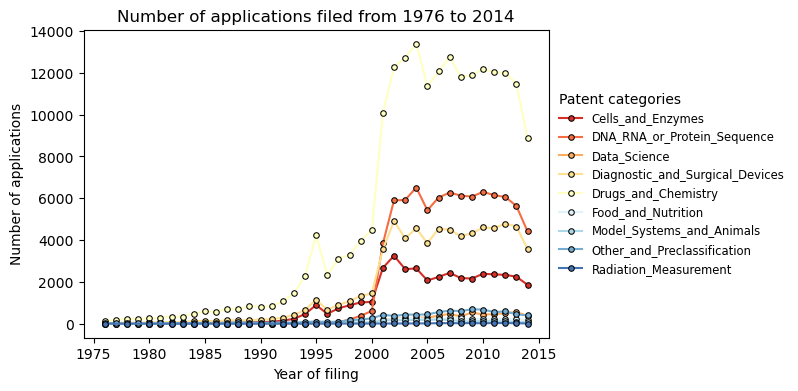

In [118]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot lineplot
lineplot(cat_moonshot_count, x='Filing_Date', y='counts', 
         hue='category', xlabel='Year of filing', ylabel='Number of applications')

# Add title
ax.set_title(
    f'Number of applications filed from '
    f'{cat_moonshot_count["Filing_Date"].min()} to '
    f'{cat_moonshot_count["Filing_Date"].max()}'
)

plt.show()
# fig.savefig('results/count-categories-by-year', dpi=150, format='png', bbox_inches='tight')

This is not so informative, as the increase in absolute counts here is likely just attributable to the publication of pending applications for the first time in 2000, as AIPA into effect (as discussed above). Of note, the "surge" of filings in 2000 is likely due to the fact that applicants were trying to file before AIPA was implemented in order to avoid pre-grant publication. And again, the slight drop in number of applications from 2014 to 2015 is likely attributable to the pre-grant publication lag.

A more informative approach may be to look at how the proportions filed in each category changes over time. We can go back to our `cat_moonshot_prop` dataset.

In [119]:
# Use custom function to get normalized counts to baseline
cat_moonshot_count = cat_moonshot_count.groupby('category', group_keys=False).apply(divide_by_baseline)

In [120]:
# Get counts normalized by the previous year's counts
cat_moonshot_count['norm_to_prev'] = (cat_moonshot_count.groupby('category', group_keys=False)['counts']
                                  .apply(lambda x: x / x.shift())
)

In [121]:
cat_moonshot_count.head()

,Filing_Date,category,counts,norm_to_baseline,norm_to_prev
0,1976,Cells_and_Enzymes,3.0,1.000000,NaN
1,1977,Cells_and_Enzymes,8.0,2.666667,2.666667
2,1978,Cells_and_Enzymes,12.0,4.000000,1.500000
3,1979,Cells_and_Enzymes,10.0,3.333333,0.833333
4,1980,Cells_and_Enzymes,14.0,4.666667,1.400000


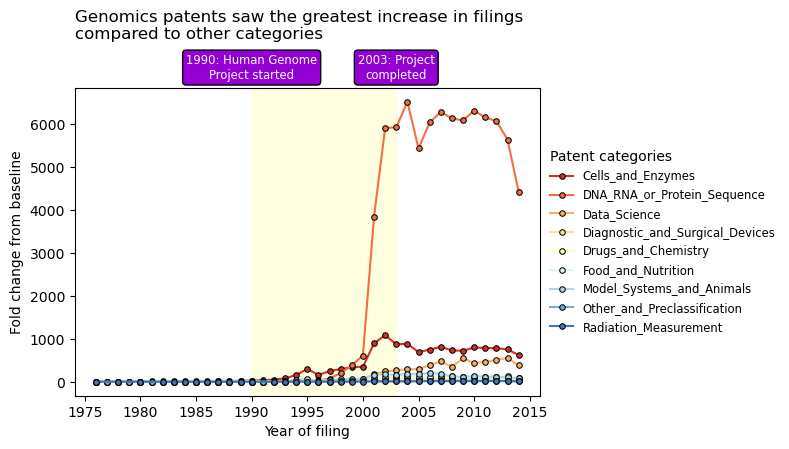

In [124]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot lineplot
lineplot(data=cat_moonshot_count, x='Filing_Date', y='norm_to_baseline', 
         hue='category', xlabel='Year of filing', ylabel='Fold change from baseline', 
         zorder=2)

# Add title
ax.set_title(
    f'Genomics patents saw the greatest increase '
    'in filings\ncompared to other categories',
    pad=35, loc='left')

# Add some annotations showing the years of HGP activity
text_kwargs = dict(fontsize='small', color='white', 
                   bbox=dict(boxstyle='round', fc='darkviolet', alpha=1), 
                   ha='center', va='bottom', 
                   transform=ax.get_xaxis_transform())
ax.text(1990, 1.02, s='1990: Human Genome\nProject started', **text_kwargs)
ax.text(2003, 1.02, s='2003: Project\ncompleted', **text_kwargs)
ax.fill_between([1990, 2003], 0, 1, color='lightyellow', transform=ax.get_xaxis_transform(), 
               zorder=1)
# ax.axvline(x=1990, ls='dashed', lw=0.8, color='black')
# ax.axvline(x=2003, ls='dashed', lw=0.8, color='black')

plt.show()
# fig.savefig('results/fold-change-categories', dpi=150, format='png', bbox_inches='tight')

An alternative way to process the data is by normalizing the number of filings each year to the number of filings in the previous year. For this visualization, let's show a narrower range of filing years, 1995-2005, since the year that we really care about is 2001.

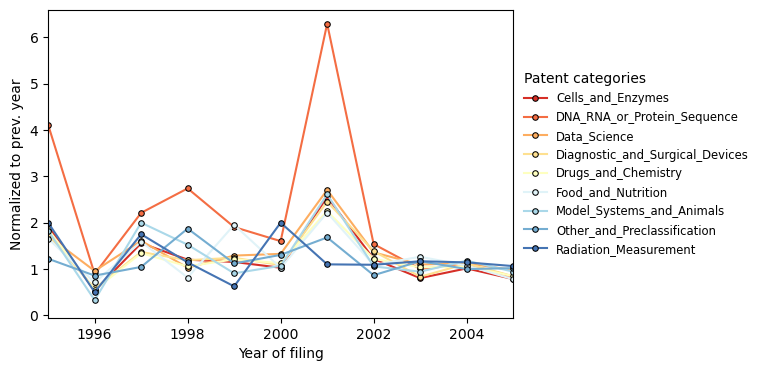

In [125]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot line plot
lineplot(data=cat_moonshot_count, x='Filing_Date', y='norm_to_prev', 
         hue='category', xlabel='Year of filing', ylabel='Normalized to prev. year')

# Set xlim to zoom in on the years around 2001
ax.set_xlim(1995, 2005)

plt.show()
# fig.savefig('results/norm-to-prev-categories', dpi=150, format='png', bbox_inches='tight')

Another visualization to try is an ECDF (empirical cumulative distribution function) plot, which represents the proportion of applications falling below each value (filing year) in the dataset. It allows us to compare the distributions of the data (number of applications filed in each filing year) between different categories.

<Axes: xlabel='Filing_Date', ylabel='Proportion'>

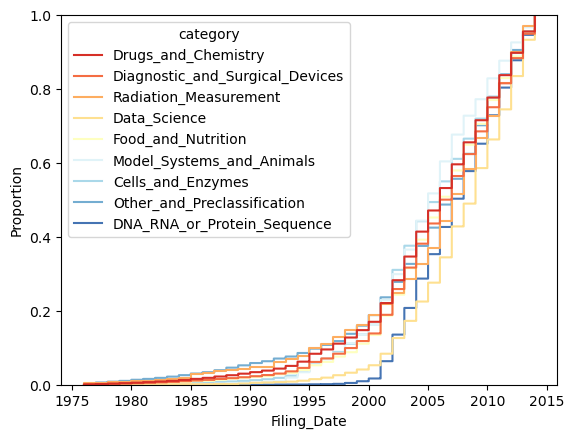

In [126]:
sns.ecdfplot(data=cat_moonshot, x=cat_moonshot["Filing_Date"].dt.year, hue="category", palette='RdYlBu')

## Inventors

Inventor information is stored in `all_inventors.csv` as part of the PatEx 2022 release. Let's merge it with `cat_moonshot` to link inventor information to the different patent categories.

Some questions for this section:
- For the first genomics applications filed in the early 2000s, where were these inventors located? How does this compare to genomics applications filed in later years?
- How does inventor team size change over time?

### Visualizing the locations of inventors on genomics-based applications

In [127]:
# Import packages for working with geospatial data
import geopandas as gpd
import geoplot as gplt

In [128]:
# Get the list of app numbers
app_numbers = cat_moonshot['Application_Number'].unique()

In [129]:
# Read in all_inventors in chunks and store filtered chunks in a generator called chunks
chunks = (chunk[chunk['application_number'].isin(app_numbers)]
         for chunk in pd.read_csv('data/all_inventors.csv', 
                 usecols = ['application_number','inventor_rank','inventor_city_name','inventor_region_code',
                           'inventor_country_code'],
                 chunksize = 10000, iterator=True))

# Create new dataframe by concatenating the individual chunks
patex_inventors = pd.concat(chunks)

In [130]:
patex_inventors.shape

(587035, 5)

In [131]:
# For this part, we don't need inventor rank information, so drop it
# and grab 'category' and 'filing_date' information from 'cat_moonshot'
inventors_loc = (patex_inventors.drop('inventor_rank', axis=1)
            .dropna(axis=0, subset='inventor_city_name')
            .merge(
                cat_moonshot[['Application_Number', 'Filing_Date', 'category']], 
                how='left', left_on='application_number', right_on='Application_Number'
            )
            .drop('Application_Number',axis=1)
            .copy()
)

For simplicity, let's only focus on US-based inventors.

In [132]:
us_inventors = inventors_loc.loc[inventors_loc['inventor_country_code'] == 'US'].copy()

In [133]:
us_inventors.head()

,application_number,inventor_city_name,inventor_region_code,inventor_country_code,Filing_Date,category
83,09403659,CHAPEL HILL,NC,US,2000-02-18,Drugs_and_Chemistry
107,09506906,Encinitas,CA,US,2000-02-18,Drugs_and_Chemistry
108,09506906,Escondido,CA,US,2000-02-18,Drugs_and_Chemistry
109,09506906,San Diego,CA,US,2000-02-18,Drugs_and_Chemistry
110,09506906,Santee,CA,US,2000-02-18,Drugs_and_Chemistry


Notice there are some city names in `us_inventors` that are capitalized. Since this might affect proper merging later on, let's convert all city names to titlecase first.

In [134]:
us_inventors['inventor_city_name'] = us_inventors['inventor_city_name'].str.title()

In one of our earlier graphs, we noticed that there was a big increase in patent applications filed with DNA/RNA/protein sequences (genomics patents) in 2001. One hypothesis is that this is related to the completion of the Human Genome Project (abbreviated as HGP) in 2003. As patents, by definition, must be novel subject matter, patent filings will generally pre-date the publication of breakthrough innovations.

It would make sense to think that these earliest applications are coming from places that were at the forefront of the HGP, or otherwise heavily involved in the development of sequencing technology. Obvious places that come to mind are the biomedical hubs in California (e.g., San Diego, San Francisco) and the east coast (Maryland, New York, Boston, etc.). If we have location data for inventors on these patent applications, we can visualize where the inventors were located. 

In [135]:
# Since we're comparing pre-2001 to post-2001 applications,
# let's first look at the pre-2001 applications
early_dna = us_inventors[(us_inventors['Filing_Date'].dt.year < 2001) 
                         & (us_inventors['category'].str.contains('DNA'))]

In [136]:
# Use custom function to generate counts and proportions
early_dna_stats = unique_and_prop(early_dna, 
                                  col='application_number',
                                  groups=['inventor_city_name', 'inventor_region_code'])

In [137]:
# Repeat for DNA/RNA apps. filed after 2000
later_dna = us_inventors[(us_inventors['Filing_Date'].dt.year >= 2001) 
                         & (us_inventors['category'].str.contains('DNA'))]

# Generate counts and proportions for 'later_dna'
later_dna_stats = unique_and_prop(later_dna, col='application_number',
                                 groups=['inventor_city_name', 'inventor_region_code'])

Now that we have some data on the locations of US-based inventors and how many patent applications were filed by inventors living in these US cities, we can plot these stats on a map to visualize the data geospatially.

First, we need a shapefile or geoJSON file that has geospatial data for US cities. The one I'm working with is from [here](https://geodata.lib.utexas.edu/catalog/stanford-bx729wr3020). Then, we also need another shapefile that has geospatial data demarcating the boundaries of US states, so that we can map the cities on top of the US states. Luckily, `geoplot` already has a sample dataset that will serve my purpose well.

In [138]:
# Load the shapefile for US cities
usa_cities = gpd.read_file('data/us_cities_2014/citiesx010g.shp')

# Load the sample dataset from geoplot that demarcates state boundaries
# of the contiguous US
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [139]:
usa_cities.head()

,GNIS_ID,ANSICODE,FEATURE,FEATURE2,NAME,POP_2010,COUNTY,COUNTYFIPS,STATE,STATE_FIPS,LATITUDE,LONGITUDE,PopPlLat,PopPlLong,ELEV_IN_M,ELEV_IN_FT,geometry
0,1028750.0,1036000,Civil,-999,Dunseith,773.0,Rolette,079,ND,38,48.813057,-100.060968,48.813057,-100.060968,520.0,1706.0,POINT (-100.06097 48.81306)
1,1030349.0,1036174,Civil,-999,Mylo,20.0,Rolette,079,ND,38,48.635278,-99.618756,48.635278,-99.618756,504.0,1654.0,POINT (-99.61876 48.63528)
2,1027718.0,1035912,Civil,-999,Antler,27.0,Bottineau,009,ND,38,48.970853,-101.282380,48.970853,-101.282380,468.0,1535.0,POINT (-101.28238 48.97085)
3,1028083.0,1035936,Civil,County Seat,Bottineau,2211.0,Bottineau,009,ND,38,48.827230,-100.445698,48.827230,-100.445698,499.0,1637.0,POINT (-100.44570 48.82723)
4,1029080.0,1036050,Civil,-999,Gardena,29.0,Bottineau,009,ND,38,48.700837,-100.497639,48.700837,-100.497639,447.0,1467.0,POINT (-100.49764 48.70084)


The columns we are interested in are `NAME`, `STATE`, and `geometry`. Since we only have the state borders for the contiguous US, we can only keep cities that are in the continental US.

In [140]:
# Keep only relevant columns and subset to cities in continental US
continental_usa_cities = usa_cities[['NAME','STATE','geometry']].query('STATE not in ["HI", "AK", "PR"]')

In [141]:
continental_usa_cities.sample(5)

,NAME,STATE,geometry
6493,Gretna,VA,POINT (-79.35891 36.95375)
14453,Norfork,AR,POINT (-92.28432 36.20951)
24139,Fontanelle,NE,POINT (-96.42808 41.53861)
24264,Atkinson Mills,PA,POINT (-77.81805 40.45535)
21893,Dougherty,OK,POINT (-97.07935 34.40348)


In [142]:
# Merge the cities shapefile with inventor information, joining on city name AND state code
data = [early_dna_stats, later_dna_stats]
merged = []

for df in data:
    merged_df = df.merge(continental_usa_cities, 
                         left_on=['inventor_city_name', 'inventor_region_code'],
                         right_on=['NAME', 'STATE'], how='inner')
    merged.append(merged_df)

In [143]:
# Initialize GeoDataFrames to be able to use geoplot
for i, df in enumerate(merged):
    merged[i] = gpd.GeoDataFrame(df)

In [144]:
# Project 'contiguous_usa' to Albers equal-area conic projection
contiguous_usa = contiguous_usa.to_crs("ESRI:102003")

# Set the cities data to the same CRS to enable layering
for df in merged:
    df = df.to_crs(contiguous_usa.crs, inplace=True)

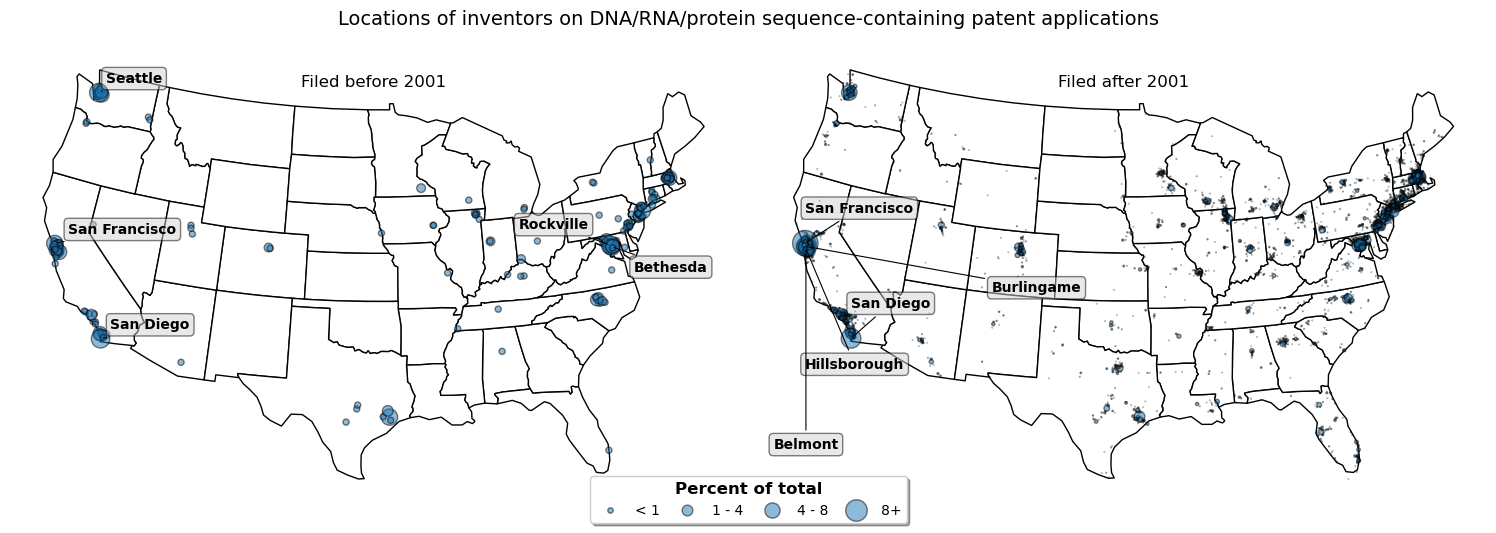

In [145]:
from matplotlib.lines import Line2D
from adjustText import adjust_text

# Set marker sizes
markers = []
for df in merged:
    markers.append(df['prop_of_total']*30)

# Initialize fig and axes
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes(rect=(0, 0, 0.5, 0.9))
ax2 = fig.add_axes(rect=(0.5, 0, 0.5, 0.9))

# Plot outline of US
for ax in ax1, ax2:
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black')

# Plot the cities
for df, marker, ax in zip(merged, markers, [ax1, ax2]):
        df.plot(ax=ax, marker='o', markersize=marker, alpha=0.5, edgecolor='black')

# Remove axis labels
for ax in ax1, ax2:
    ax.set_axis_off()

# Make custom legend elements that are plotted outside the figure (at lat=lon=0).
# This makes it easier to populate the legend box with circles of exact 
# sizes and colors.
legend_elements = [
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(0.5*30), label='< 1', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(2*30), label='1 - 4', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(4*30), label='4 - 8', markeredgecolor='black'),
    Line2D([], [], lw=0, marker='o', alpha=0.5, markersize=np.sqrt(8*30), label='8+', markeredgecolor='black')
]

fig.legend(handles=legend_elements, ncols=4, markerscale=1, shadow=True, 
           fancybox=True, columnspacing=1.0, loc='center', fontsize=10, 
           bbox_to_anchor=(0.5, 0), title="Percent of total", 
           title_fontproperties=dict(weight='semibold', size=12));

# Set subplot titles and fig title
ax1.set_title('Filed before 2001', y=0.9)
ax2.set_title('Filed after 2001', y=0.9)
fig.suptitle('Locations of inventors on DNA/RNA/protein sequence-containing patent applications', 
             fontsize=14)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.01)

# Add label annotations for top 5 cities
top_early = (merged[0]
         .sort_values(by='prop_of_total', ascending=False)
         .head(5)
)
top_later = (merged[1]
         .sort_values(by='prop_of_total', ascending=False)
         .head(5)
)

early_labels = []
for idx, row in top_early.iterrows():
    t = ax1.text(s=row['inventor_city_name'], x=row['geometry'].x, y=row['geometry'].y,
                 fontsize=10, fontweight='semibold', 
                 bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor='black', alpha=0.5))
    early_labels.append(t)

later_labels = []
for idx, row in top_later.iterrows():
    t = ax2.text(s=row['inventor_city_name'], x=row['geometry'].x, y=row['geometry'].y,
                 fontsize=10, fontweight='semibold', 
                 bbox=dict(boxstyle='round', facecolor='lightgray', edgecolor='black', alpha=0.5))
    later_labels.append(t)

# Adjust annotations
adjust_text(early_labels, 
            only_move={'points':'xy', 'text':'xy'}, 
            force_points=5, 
            force_text=5,
            arrowprops=dict(arrowstyle="-", color='black', lw=0.8), 
            ax=ax1)
adjust_text(later_labels, 
            only_move={'points':'y', 'text':'xy'}, 
            force_points=20, 
            force_text=5, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.8), ax=ax2) 

plt.show()
# fig.savefig('results/loc-of-inventors', format='png', dpi=150, bbox_inches='tight')

### Change in inventor group sizes over time

In [146]:
inventor_size = patex_inventors.copy()
# Get the inventor group size by finding the max of the inventor_rank for each application
inventor_size = inventor_size.groupby('application_number')[['inventor_rank']].max()

In [147]:
# Merge with 'cat_moonshot' data to get category and filing date info
inventor_size = inventor_size.merge(cat_moonshot, left_on='application_number', right_on='Application_Number')

In [148]:
inventor_size.head()

,inventor_rank,Application_Number,Filing_Date,category
0,1,05652848,1976-01-27,Drugs_and_Chemistry
1,1,05654452,1976-02-02,Drugs_and_Chemistry
2,1,05679431,1976-04-22,Diagnostic_and_Surgical_Devices
3,1,05687505,1976-05-18,Drugs_and_Chemistry
4,1,05696321,1976-06-14,Diagnostic_and_Surgical_Devices


In [149]:
# Get the count and average inventor group size for each filing year
inventor_size_stats = (inventor_size
                     .groupby(inventor_size['Filing_Date'].dt.year)['inventor_rank']
                     .agg(['mean', 'count'])
                     .reset_index()
)

# Get the count and average group size for each category, grouped by filing year
inventor_size_stats_cat = (inventor_size
                     .groupby([inventor_size['Filing_Date'].dt.year, 'category'])['inventor_rank']
                     .agg(['mean', 'count'])
                     .reset_index()
)

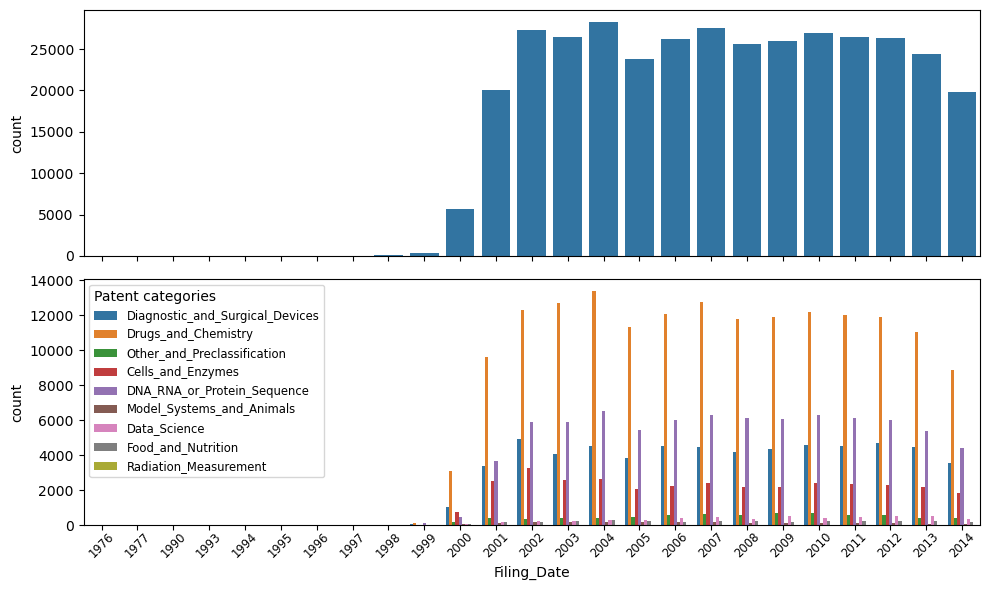

In [150]:
# Initialize fig and axes
fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True, layout='tight')

sns.barplot(data=inventor_size_stats, x='Filing_Date', y='count', ax=axs[0])
sns.barplot(data=inventor_size_stats_cat, x='Filing_Date', y='count', hue='category', ax=axs[1])

# Adjust legend properties
axs[1].legend(title='Patent categories', fontsize='small', alignment='left')

# Adjust positioning of x-axis labels
for ax in axs:
    ax.tick_params(axis='x', labelsize='small', rotation=45, pad=0.1)
    ax.label_outer()

plt.show()

[(2000.0, 2015.0), (3.0, 5.0)]

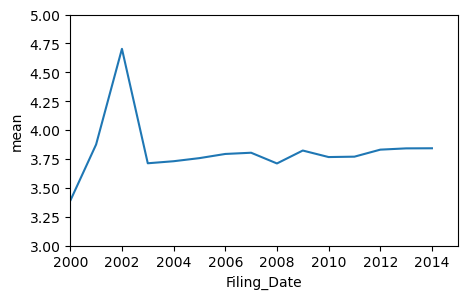

In [151]:
# Initialize fig and axes
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(
    data=inventor_size_stats, 
    x='Filing_Date', y='mean', ax=ax)

ax.set(xlim=(2000, 2015), ylim=(3, 5))

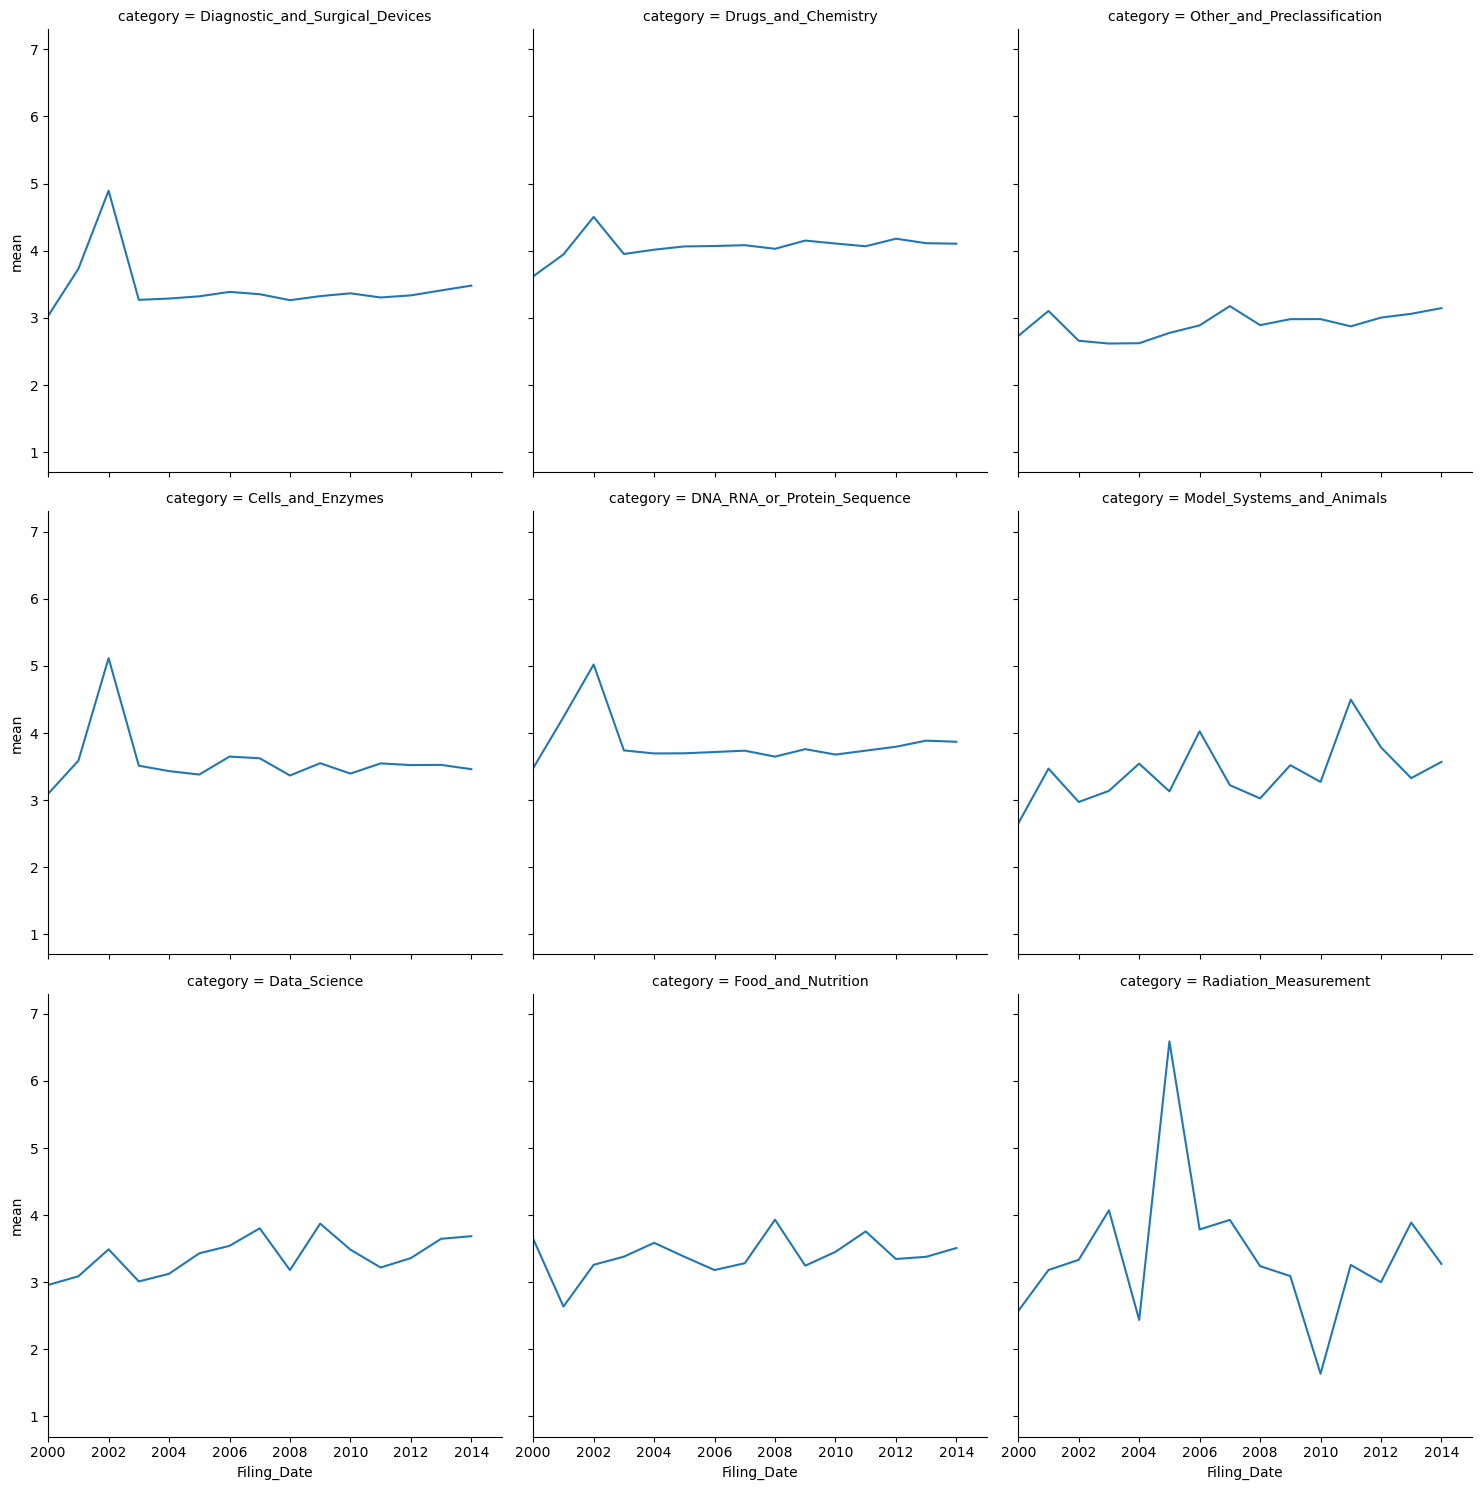

In [152]:
# Visualize the average inventor group size in different filing years
# with categories represented on separate facets of the grid
g = sns.relplot(
    data=inventor_size_stats_cat, 
    x='Filing_Date', y='mean', 
    col='category', col_wrap=3, 
    kind='line')
# Set xlim minimum to 2000
g.set(xlim=(2000, 2015))

Interestingly and a bit oddly, there appears to be a spike in the size of inventor groups in 2002 for certain categories, e.g., diagnostic and surgical devices, drugs and chemistry, cells and enzymes, and genomics. 